## Facial keypoints detection

The goal of this project is to create a detector for keypoints on facial images.
To do this, a CNN regression model is created and then trained 
This notebook contains a facial keypoint detector based on CNN regression.

![title](example.png)

### Load and preprocess data

In [5]:
### Useful routines for preparing data
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import os
import numpy as np
import pandas as pd

def load_imgs_and_keypoints(dirname='data/images'):
    crop_size = 100
    images_list = []
    i = 0
    
    coordinates = pd.read_csv('data/gt.csv', sep=',') 
    points = array(coordinates.values[:,1:])
    
    for root, dirs, files in os.walk(dirname):
        for each_file in files:
            image_path = dirname + '/' + each_file
            each_image = imread(image_path)
            for j in range(0,points.shape[1],2):
                points[i,j] = points[i,j]/each_image.shape[0] - 0.5
                points[i,j+1] = points[i,j+1]/each_image.shape[1] - 0.5
            i = i+1           
            each_image = resize(each_image, (crop_size,crop_size))
            if len(each_image.shape) != 3: #If image is grayscale, convert to RGB
                each_image = gray2rgb(each_image)
            images_list.append(each_image) 
            
    images = zeros((len(images_list),crop_size,crop_size,3))
    images = array(images_list)
    
    return images, points


imgs, points = load_imgs_and_keypoints()


C:\Users\brook\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


C:\Users\brook\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Users\brook\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


array([-0.3053435114503817, -0.3053435114503817, -0.01526717557251911,
       -0.27099236641221375, 0.14503816793893132, -0.25190839694656486,
       0.2748091603053435, -0.3015267175572519, -0.24045801526717558,
       -0.20610687022900764, -0.17557251908396948, -0.2137404580152672,
       -0.08015267175572521, -0.18702290076335876, 0.11068702290076338,
       -0.16793893129770993, 0.15267175572519087, -0.1984732824427481,
       0.23664122137404575, -0.17938931297709926, 0.09541984732824427,
       0.04961832061068705, -0.1488549618320611, 0.16412213740458015,
       0.03435114503816794, 0.1870229007633588, 0.14122137404580148,
       0.18320610687022898], dtype=object)

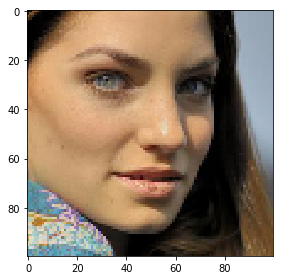

In [6]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

Visualize images with keypoints shown as red dots on each image.

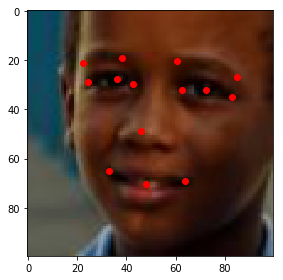

In [7]:
import matplotlib.pyplot as plt

def visualize_points(img, points):
    # img is a rgb array
    # points is an array of xy coordinates, in the following format:
    #   x0, y0, x1, y1, x2, y2 .... etc.
    
    fig, ax = plt.subplots(figsize=(4,4))
    plt.imshow(img)
    x = []
    y = []
    for i in range(0,points.shape[0],2):
        # Convert xy coordinates from -0.5:0.5 to 0:100
        x.append((points[i]+.5)*100)
        y.append((points[i+1]+.5)*100)
    x = array(x)
    y = array(y)
    plt.plot(x,y,'ro')
    plt.tight_layout()
    pass
    
visualize_points(imgs[1], points[1])

### Split data set

Split the data into two groups: a training set and a validation set.

In [9]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training I used simple data augmentation — flipping an image and its corresponding points.

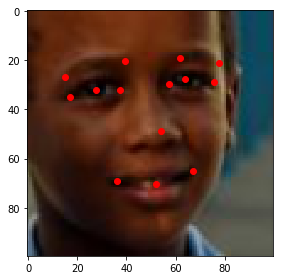

In [10]:
 def reorder_points(points, p1, p2):
    # Points are stored as an array: x0, y0, x1, y1, x2, y2, etc.
    index1 = p1*2
    index2 = p2*2
    reordered_points = np.copy(points)

    reordered_points[index1] = points[index2]
    reordered_points[index1+1] = points[index2+1]
    reordered_points[index2] = points[index1]
    reordered_points[index2+1] = points[index1+1] 
    
    return reordered_points

def flip_img(img, points):
    # Flip points right to left
    f_points = []
    for i in range(0,points.shape[0],2):      
        f_points.append(points[i]*(-1))
        f_points.append(points[i+1])
    f_points = array(f_points)
    
    # Reorder points in array
    f_points = reorder_points(f_points, 0, 3)
    f_points = reorder_points(f_points, 1, 2)
    f_points = reorder_points(f_points, 4, 9)
    f_points = reorder_points(f_points, 5, 8)
    f_points = reorder_points(f_points, 6, 7)
    f_points = reorder_points(f_points, 11, 13)
   
    # Flip image right to left
    f_img = np.flip(img,axis=1)
    return f_img, f_points

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

In [11]:
# Flip all images and keypoints
# Combine flipped images/keypoints and originals
aug_imgs_train = []
aug_points_train = []
for i in range(0,imgs.shape[0]):
    f_img, f_points = flip_img(imgs[i], points[i])
    aug_imgs_train.append(imgs[i])
    aug_imgs_train.append(f_img)
    aug_points_train.append(points[i])
    aug_points_train.append(f_points)
    
aug_imgs_train = array(aug_imgs_train)
aug_points_train = array(aug_points_train)

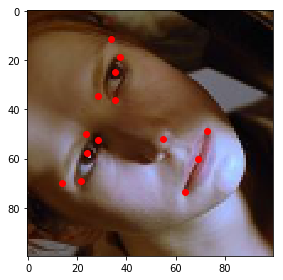

In [12]:
visualize_points(aug_imgs_train[4], aug_points_train[4])

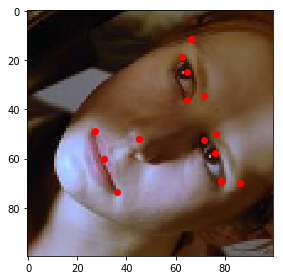

In [13]:
visualize_points(aug_imgs_train[5], aug_points_train[5])

### Network architecture and training

The neural network has 28 outputs, 2 numbers per point.

In [15]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, Reshape, LeakyReLU
)
image_size = 100
num_classes = 28
model = Sequential()

# Add 2-3 Conv2D + MaxPooling2D pairs
model.add(Conv2D(32, kernel_size=(3,3), input_shape=(aug_imgs_train[0].shape), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same',))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# Flatten
model.add(Flatten())

# Add 2-3 Dense layers with Dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes))
    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 21632)             0         
__________

In [16]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

batch_size = 64
epochs = 10

# Compile Model
model.compile(optimizer=Adam(), loss='mse', metrics=['accuracy'])

# Fit Model
ModelCheckpoint('summary.txt')
trained_model = model.fit(aug_imgs_train, aug_points_train, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, validation_data=(imgs_val,points_val))


Train on 12000 samples, validate on 600 samples
Epoch 1/10
12000/12000 [==============================] - 268s 22ms/step - loss: 0.0070 - acc: 0.6274 - val_loss: 0.0026 - val_acc: 0.8033
Epoch 2/10
12000/12000 [==============================] - 259s 22ms/step - loss: 0.0026 - acc: 0.7964 - val_loss: 0.0019 - val_acc: 0.8333
Epoch 3/10
12000/12000 [==============================] - 249s 21ms/step - loss: 0.0021 - acc: 0.8341 - val_loss: 0.0015 - val_acc: 0.8367
Epoch 4/10
12000/12000 [==============================] - 245s 20ms/step - loss: 0.0018 - acc: 0.8492 - val_loss: 0.0014 - val_acc: 0.8383
Epoch 5/10
12000/12000 [==============================] - 245s 20ms/step - loss: 0.0017 - acc: 0.8572 - val_loss: 0.0011 - val_acc: 0.8433
Epoch 6/10
12000/12000 [==============================] - 243s 20ms/step - loss: 0.0015 - acc: 0.8598 - val_loss: 0.0011 - val_acc: 0.8350
Epoch 7/10
12000/12000 [==============================] - 236s 20ms/step - loss: 0.0014 - acc: 0.8647 - val_loss: 0.00

### Visualize results

Model is used to predict key facial points on sample images.

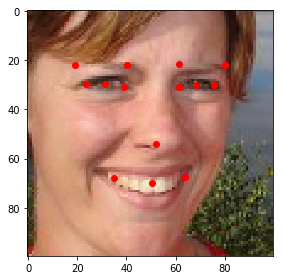

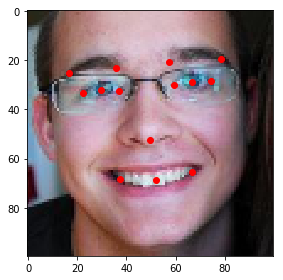

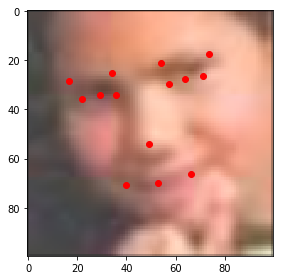

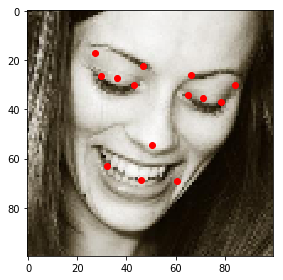

In [36]:
prediction = model.predict(imgs_val)
visualize_points(imgs_val[55], prediction[55])
visualize_points(imgs_val[56], prediction[56])
visualize_points(imgs_val[47], prediction[47])
visualize_points(imgs_val[89], prediction[89])

This project was completed as an assignment in https://www.coursera.org/learn/deep-learning-in-computer-vision/